To activate virtualenv type in terminal: source /home/pepe/.virtualenvs/SoilDetectionV2/bin/activate

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


2024-05-23 20:08:48.246167: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 20:08:49.114929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# errors resolved with setting this:
# export CUDNN_PATH="$HOME/.local/lib/python3.10/site-packages/nvidia/cudnn"
#                          (/home/pepe/.local/lib/python3.10/site-packages/nvidia/cudnn)
# 
# export LD_LIBRARY_PATH="$CUDNN_PATH/lib":"/usr/local/cuda/lib64"
#     (/home/pepe/.local/lib/python.10/site-packages/nvidia/cudnn/lib:/usr/local/cuda/lib64)
#                          /\ MAINLY THIS RESOLVED AN ISSUE /\
# and also installed: "pip install tensorflow[and-cuda]" globally

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-23 20:08:50.070418: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 20:08:50.093002: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 20:08:50.093039: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
batch_size = 64
epochs = 40
img_height = 224
img_width = 224
color_channels = 3
dataset_dir = "./Soil_dataset"
seed=1

In [4]:
train_ds, validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    labels="inferred",
    color_mode='rgb',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=seed,
    validation_split=0.1,
    subset="both",
    interpolation="bicubic",
    data_format="channels_last",
    verbose=True
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Class names:", class_names)

Found 483 files belonging to 5 classes.
Using 435 files for training.
Using 48 files for validation.


2024-05-23 20:08:50.166722: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 20:08:50.166795: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 20:08:50.166817: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 20:08:50.311399: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 20:08:50.311465: I external/local_xla/xla/stream_executor

Class names: ['Czarnoziem', 'Gleba gliniana', 'Gleba torfowa', 'Gleba wapienna', 'Piasek']


2024-05-23 20:08:51.633124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


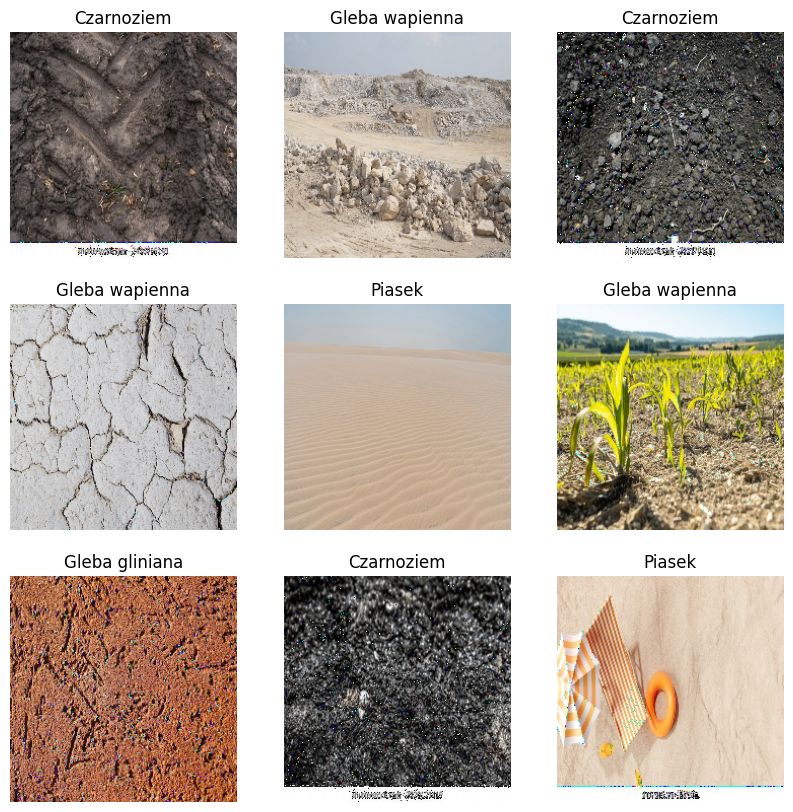

In [5]:
# Nie da się wziąsć jednego elementu, trzeba cały batch i forem ekstraktować
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        offset = 20
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i+offset].numpy().astype("uint8"))
        plt.title(class_names[labels[i+offset]])
        plt.axis("off")

plt.show()


In [6]:
# base_model = tf.keras.applications.ResNet152(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classifier_activation='softmax'
# )
# # 
# # base_model.layers.pop()
# # base_model.trainable = False
# 
# base_model.summary()

In [7]:
# inputs = tf.keras.Input(shape=(img_width, img_height, color_channels))
# x = base_model(inputs, training=False)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# outputs = tf.keras.layers.Dense(len(class_names))(x)
# model = tf.keras.Model(inputs, outputs)
model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary(print_fn=print)

Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼─────────────────────

In [8]:
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/40


I0000 00:00:1716487733.865716    1879 service.cc:145] XLA service 0x7f0bd80064d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716487733.865783    1879 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-05-23 20:08:53.932672: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-23 20:08:54.186465: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-05-23 20:09:02.993683: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at xla_ops.cc:580 : INTERNAL: XLA requires ptxas version 11.8 or higher
2024-05-23 20:09:02.993748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INTERNAL: XLA requires ptxas version 11.8 or higher
	 [[{{node StatefulPartitionedCall}}]]


InternalError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_1823/2939972061.py", line 1, in <module>

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/home/pepe/.virtualenvs/SoilDetectionV2/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

XLA requires ptxas version 11.8 or higher
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_3153]